In [33]:
%pip install matplotlib seaborn


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [34]:
import pandas as pd

df = pd.read_csv('output/k6-lint-results.csv')
# limpar nomes das colunas
df.columns = df.columns.str.lower().str.strip()


# limpar valores string em todas as colunas do tipo object
df = df.apply(lambda col: col.str.lower().str.strip() if col.dtype == "object" else col)

# mostrar formato final
df.shape

(500, 13)

In [35]:
# Remove arquivos que não conseguiu clonar
df = df[df['file_exists'] == 'yes']

# Remove as colunas que não importam
df.drop(columns=['url','file_exists','clone_error'], inplace=True)
df.shape

(500, 10)

In [36]:
# df = df[(df['k6-performance/no-heavy-init-context'] != 0) | (df['k6-performance/require-check'] != 0) | (df['k6-performance/require-tags'] != 0) | (df['k6-performance/require-thresholds'] != 0)]

#Adiciona uma coluna com o total de smells em cada repositorio
violation_cols = [c for c in df.columns if c.startswith('k6-performance/') and not c.endswith('_loc')]
df['total_violations'] = df[violation_cols].sum(axis=1)

#remove repositorios sem smell
# df = df[df['total_violations'] > 0]

df.shape

(500, 11)

In [37]:
# agregações básicas: soma de violações por repositório
violations_by_repo = df.groupby('repositório')['total_violations'].sum().sort_values(ascending=False).head(20)
violations_by_repo

repositório
vifor/faas-to-iaas-migration-framework                           28
boavizta/ecobenchmark-applicationweb-backend                     22
mateusoliveiraps/k6_estudos                                      17
pagopa/pn-load-test                                              17
firmansyah-github/quarkus-generated-test                         15
jwcastillo/0_to_100_k6                                           13
rxtcp/dissertation-on-measuring-system-performance-indicators    11
kotoant/spring-petclinic-rest                                    11
tomkaith13/session-based-dataprocessing                          10
bcwilsondotcom/nx-monorepo-template                              10
hyperspace-metaverse/xk6-socketio                                10
weaviate/xk6-weaviate                                             9
saifautomatron/k6                                                 9
jamesgrant1811/k6-udemy                                           9
mattpchoy/microservicearchitecture  

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

os.makedirs('output/img', exist_ok=True)
IMG_OUTPUT_FOLDER = 'output/img/'
# garante que a pasta de saída exista (não redefine IMG_OUTPUT_FOLDER)
os.makedirs(IMG_OUTPUT_FOLDER, exist_ok=True)

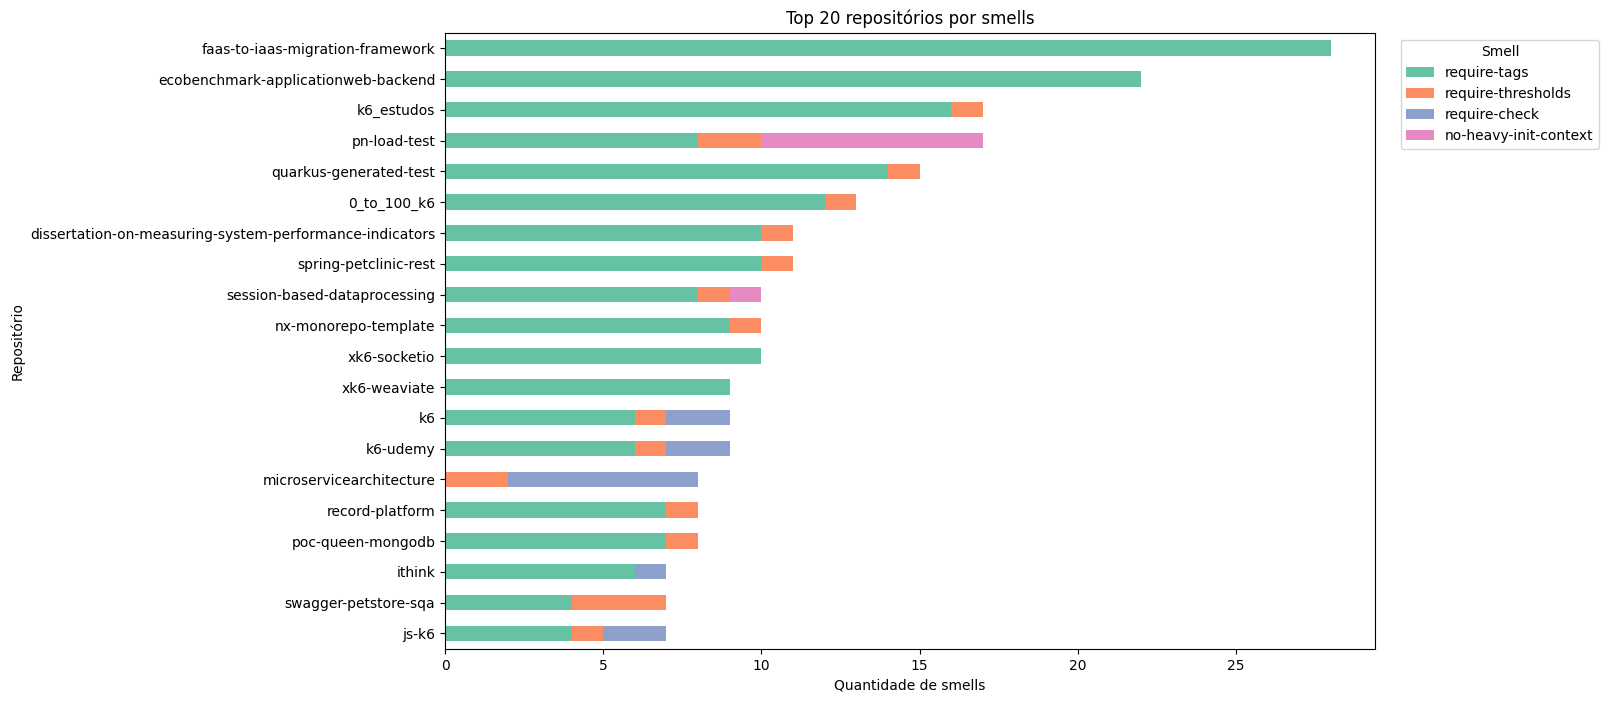

In [46]:
# Gráfico de barras empilhadas com as 4 smells mais comuns por repositório
top_repos = violations_by_repo.index.tolist()  # top 20 já calculados em cell 4

# Seleciona as 4 smells mais comuns (recalcula para garantir que existe)
top_4_smells = df[violation_cols].sum().sort_values(ascending=False).head(4).index.tolist()

# Agrega soma de cada smell por repositório, mantendo a ordem dos top repos
stacked_df = df[df['repositório'].isin(top_repos)].groupby('repositório')[top_4_smells].sum().loc[top_repos]

# nomes limpos para legendas/labels
clean_names = [s.replace('k6-performance/', '') for s in top_4_smells]

fig, ax = plt.subplots(figsize=(12, 8))
colors = plt.cm.Set2.colors[:len(top_4_smells)]  # paleta de cores

# plot horizontal empilhado (cada coluna uma smell)
stacked_df.plot(kind='barh', stacked=True, ax=ax, color=colors)

ax.set_xlabel('Quantidade de smells')
ax.set_ylabel('Repositório')
ax.set_title('Top 20 repositórios por smells')
# tornar rótulos mais legíveis
labels = [r.split('/', 1)[1] if '/' in r else r for r in stacked_df.index]
ax.set_yticklabels(labels)
plt.gca().invert_yaxis()  # manter maior no topo

# legenda com nomes limpos
ax.legend(clean_names, title='Smell', bbox_to_anchor=(1.02, 1), loc='upper left')

# plt.tight_layout()
output_file = os.path.join(IMG_OUTPUT_FOLDER, 'smells_by_repo.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

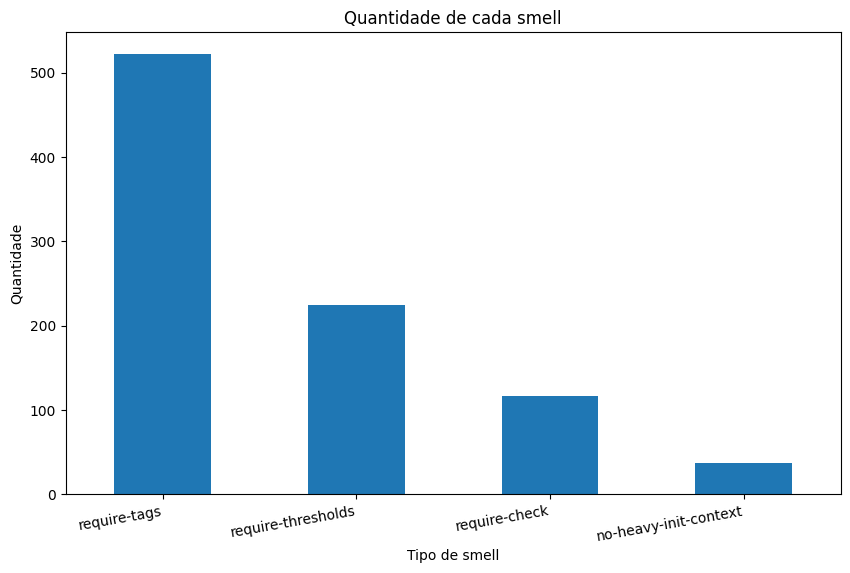

In [40]:
smell_counts = df[violation_cols].sum().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
smell_counts.plot(kind='bar', ax=ax)
ax.set_title('Quantidade de cada smell')
ax.set_xlabel('Tipo de smell')
ax.set_ylabel('Quantidade')
ax.set_xticklabels([lbl.get_text().replace('k6-performance/', '') for lbl in ax.get_xticklabels()], rotation=10, ha='right')
# fig.tight_layout()
plt.show()
fig.savefig(IMG_OUTPUT_FOLDER + 'smell_counts.png', dpi=300, bbox_inches='tight')
plt.close(fig)

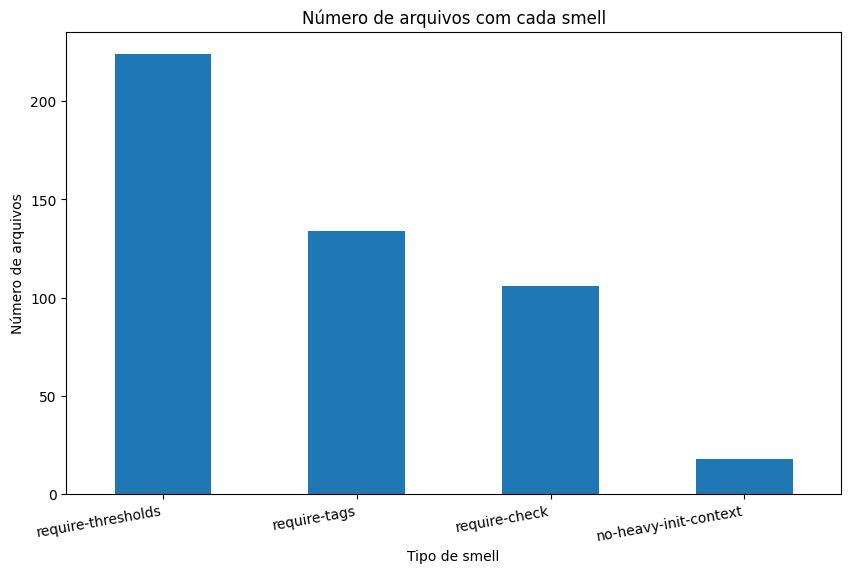

In [41]:
# Contar número de arquivos (linhas) que apresentam cada smell
# Para cada coluna de smell, conta quantas linhas têm valor > 0
smell_file_counts = (df[violation_cols] > 0).sum().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
smell_file_counts.plot(kind='bar', ax=ax)
ax.set_title('Número de arquivos com cada smell')
ax.set_xlabel('Tipo de smell')
ax.set_ylabel('Número de arquivos')
# Ajusta rótulos removendo o prefixo 'k6-performance/' para ficar mais legível
ax.set_xticklabels([lbl.get_text().replace('k6-performance/', '') for lbl in ax.get_xticklabels()], rotation=10, ha='right')
# fig.tight_layout()
plt.show()
fig.savefig(IMG_OUTPUT_FOLDER + 'smell_files_count.png', dpi=300, bbox_inches='tight')
plt.close(fig)

/tmp/ipykernel_15266/3260433497.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([lbl.get_text().replace('k6-performance/', '') for lbl in ax.get_xticklabels()])


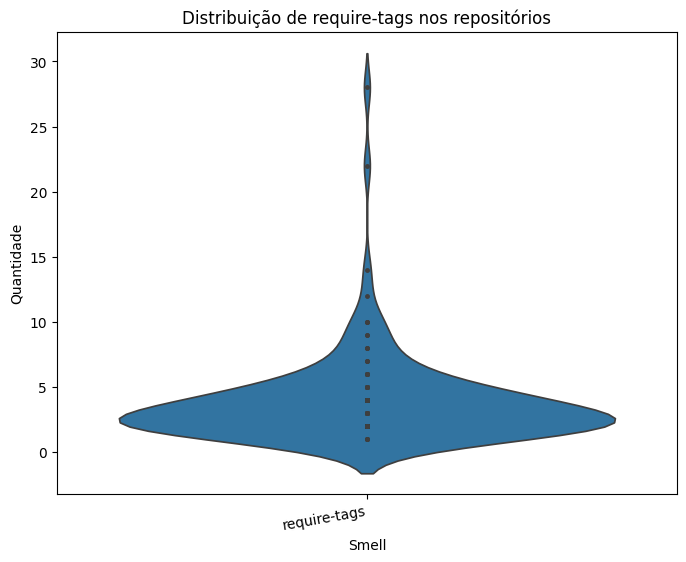

/tmp/ipykernel_15266/3260433497.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([lbl.get_text().replace('k6-performance/', '') for lbl in ax.get_xticklabels()])


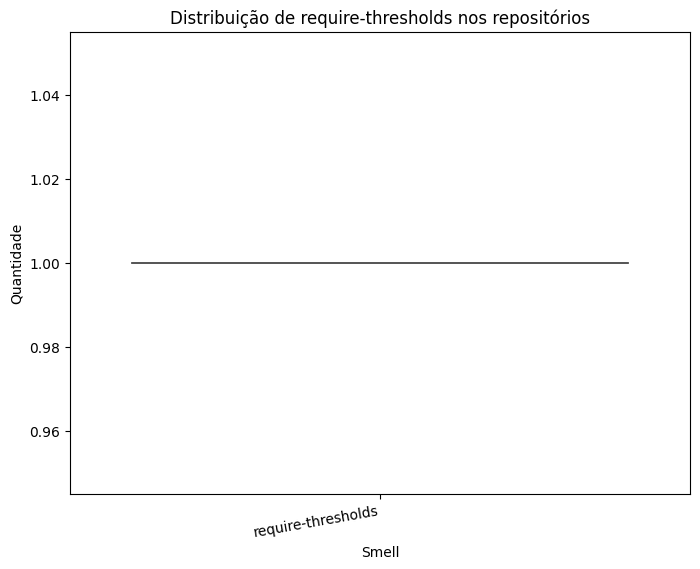

/tmp/ipykernel_15266/3260433497.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([lbl.get_text().replace('k6-performance/', '') for lbl in ax.get_xticklabels()])


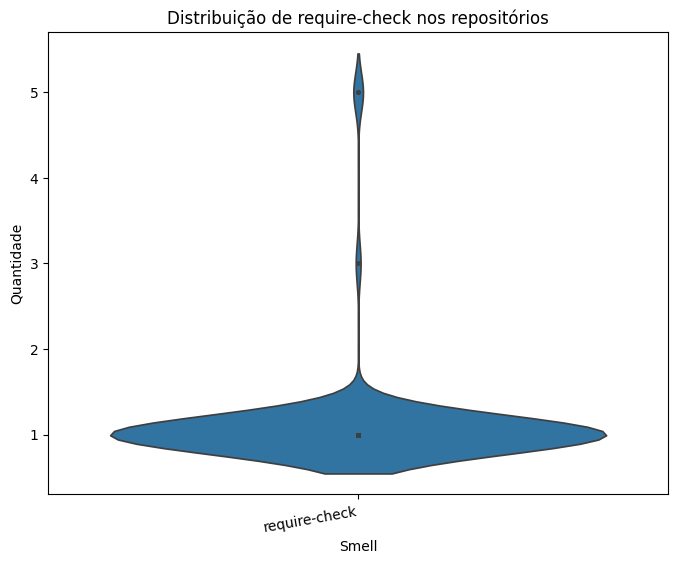

/tmp/ipykernel_15266/3260433497.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([lbl.get_text().replace('k6-performance/', '') for lbl in ax.get_xticklabels()])


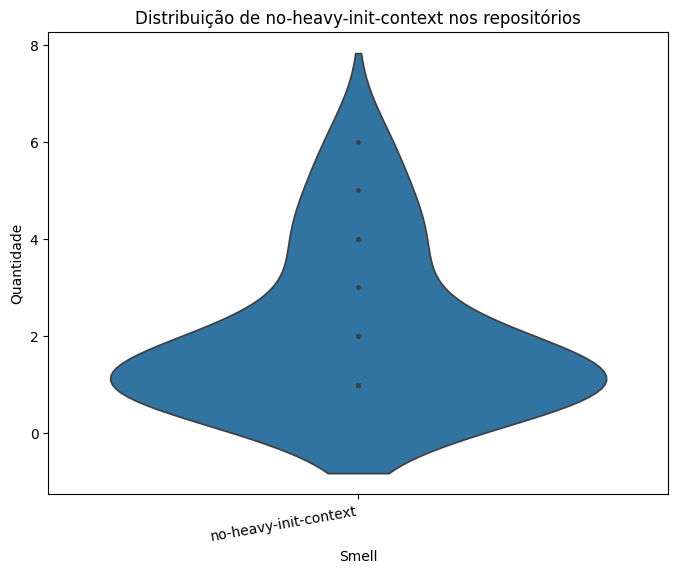

In [42]:
# Melt the DataFrame to long format for plotting
df_melted = df.melt(value_vars=violation_cols, var_name='Smell Type', value_name='Violation Count')
df_melted = df_melted[df_melted['Violation Count'] > 0]

# Get the top 4 smells based on total occurrences
top_4_smells = smell_counts.head(4).index.tolist()

for smell_type in top_4_smells:
    df_smell = df_melted[df_melted['Smell Type'] == smell_type]
    clean_name = smell_type.replace('k6-performance/', '').replace('/', '_')

    if not df_smell.empty:
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.violinplot(x='Smell Type', y='Violation Count', data=df_smell, inner='points', ax=ax)
        ax.set_title(f'Distribuição de {clean_name} nos repositórios')
        ax.set_xlabel('Smell')
        ax.set_ylabel('Quantidade')
        plt.xticks(rotation=10, ha='right')
        ax.set_xticklabels([lbl.get_text().replace('k6-performance/', '') for lbl in ax.get_xticklabels()])
        # plt.tight_layout()

        # Salvar antes de mostrar
        out_file = os.path.join(IMG_OUTPUT_FOLDER, f'violin_{clean_name}.png')
        fig.savefig(out_file, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close(fig)
    else:
        print(f"No violations found for {clean_name}")

In [43]:
# Filter the original DataFrame to include only the top repositories with the most violations
top_repos = violations_by_repo.index
df_top_repos = df[df['repositório'].isin(top_repos)]

# Display the filtered DataFrame
display(df_top_repos)

,repositório,arquivo,k6-performance/no-heavy-init-context,k6-performance/no-heavy-init-context_loc,k6-performance/require-check,k6-performance/require-check_loc,k6-performance/require-tags,k6-performance/require-tags_loc,k6-performance/require-thresholds,k6-performance/require-thresholds_loc,total_violations
28,mattpchoy/microservicearchitecture,src/soak.js,0,NaN,1,12:1,0,NaN,1,4:14,2
29,mattpchoy/microservicearchitecture,src/constantload.js,0,NaN,5,75:17; 80:17; 85:17; 102:17; 107:17,0,NaN,1,22:14,6
40,kotoant/spring-petclinic-rest,script.js,0,NaN,0,NaN,10,146:26; 159:24; 168:26; 172:25; 175:23; 178:25...,1,5:14,11
69,jamesgrant1811/k6-udemy,groups.js,0,NaN,0,NaN,4,15:19; 19:13; 20:13; 26:9,0,NaN,4
70,jamesgrant1811/k6-udemy,custom-metrics-example.js,0,NaN,1,18:1,2,19:15; 23:11,0,NaN,3
71,jamesgrant1811/k6-udemy,random-sleep.js,0,NaN,1,10:1,0,NaN,1,5:14,2
109,mateusoliveiraps/k6_estudos,k6-load.js,0,NaN,0,NaN,8,44:21; 62:23; 86:24; 103:25; 130:23; 149:27; 1...,1,15:14,9
110,mateusoliveiraps/k6_estudos,k6-smoke.js,0,NaN,0,NaN,8,45:21; 63:23; 87:24; 104:25; 131:23; 150:27; 1...,0,NaN,8
118,rxtcp/dissertation-on-measuring-system-perform...,script.js,0,NaN,0,NaN,10,146:26; 159:24; 168:26; 172:25; 175:23; 178:25...,1,5:14,11
125,saifautomatron/k6,fundamentals/groups_tags.js,0,NaN,0,NaN,4,15:19; 19:13; 20:13; 26:9,0,NaN,4


In [44]:
# Function to identify outliers using IQR
def identify_outliers(df, smell_col):
    Q1 = df[smell_col].quantile(0.25)
    Q3 = df[smell_col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[smell_col] < lower_bound) | (df[smell_col] > upper_bound)]
    return outliers[['repositório', 'arquivo', smell_col]].rename(columns={smell_col: 'violation_count'})

# Identify and display outliers for each smell type in df_top_repos
for smell_col in violation_cols:
    outliers_df = identify_outliers(df_top_repos[df_top_repos[smell_col] > 0], smell_col) # Only consider rows with violations for outlier detection
    if not outliers_df.empty:
        print(f"Outliers for {smell_col.replace('k6-performance/', '')}:")
        display(outliers_df)
    else:
        print(f"No outliers found for {smell_col.replace('k6-performance/', '')}")

No outliers found for no-heavy-init-context
Outliers for require-check:


,repositório,arquivo,violation_count
29,mattpchoy/microservicearchitecture,src/constantload.js,5


Outliers for require-tags:


,repositório,arquivo,violation_count
170,vifor/faas-to-iaas-migration-framework,scripts/load-testing/utils/validation.js,28
195,boavizta/ecobenchmark-applicationweb-backend,validator/scenario.js,22


No outliers found for require-thresholds
